In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

| Column                         | Description   |
|--------------------------------|------------------------------------|
| issuercountrycode              | country where the card was issued |
| txvariantcode                  | the card type that was used (subbrand of visa or master card) |
| bin                            | card issuer identifier |
| amount/currencycode | transaction amount in minor units (so 100 EUR = 100 euro cent) |
| shoppercountrycode | IP address country |
| shopperinteraction | Ecommerce if it was an online transaction, ContAuth if it was a (monthly) subscription, POS if the card was used at Point of Sale |
| simple_journal| Payment status. Authorised = “transaction approved and no fraud reported”, Refused = “transaction was declined, can be fraud, but can also be insufficient funds, etc”, Chargeback = “transaction was approved, but turned out to be fraud” |
| bookingdate| only relevant for Chargebacks. Time stamp when the chargeback was reported. During simulation you may only use this knowledge after this date. So for example if on an email address a transaction ended in a chargeback, you can only block that email address after the booking date of the chargeback.|
| cardverificationresponsesupplied | did the shopper provide his 3 digit CVC/CVV2 code? |
| cvcresponsecode | Validation result of the CVC/CVV2 code: 0 = Unknown, 1=Match, 2=No Match, 3-6=Not checked |
| creationdate | Date of transaction |
| accountcode | merchant’s webshop |
| mail_id | Email address |
| ip_id | Ip address |
| card_id | Card number | 

## Read Data

In [2]:
data = pd.read_csv("data/data_for_student_case.csv")
data.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


## Data statistics

In [3]:
number_of_rows = len(data)
number_of_authorised = len(data[data['simple_journal'] == 'Settled'])
number_of_fraud = len(data[data['simple_journal'] == 'Chargeback'])
number_of_refused = len(data[data['simple_journal'] == 'Refused'])
print(f"Number of transactions: {number_of_rows} \nAuthorised: {number_of_authorised} \nFraud: {number_of_fraud} \n(Refused: {number_of_refused})")

Number of transactions: 290382 
Authorised: 236691 
Fraud: 345 
(Refused: 53346)


## Data Preprocessing

In [15]:
# The class label needs to be determined. 
# We can neglect the refused cases since we don't know if it was fraud or not.
# We assign class 1 for Chargeback and class 0 for Settled
pdata = data.loc[~(data["simple_journal"] == "Refused")]
pdata.loc[pdata["simple_journal"] == "Settled", "simple_journal"] = 0
pdata.loc[pdata["simple_journal"] == "Chargeback", "simple_journal"] = 1

# We assign 0 if the transaction was done online, 1 if it was a (montly) subscription,
# and 2 if the card was used at a POS.
# pdata.loc[pdata["shopperinteraction"] == "Ecommerce", "shopperinteraction"] = 0
# pdata.loc[pdata["shopperinteraction"] == "ContAuth", "shopperinteraction"] = 1
# pdata.loc[pdata["shopperinteraction"] == "POS", "shopperinteraction"] = 2

# To prepare the data to run a model on it we have to convert the non-number
# columns into (machine-understandable) numerical values.
# Relevant columns (possibly) include the mail_id, ip_id, card_id, shopperinteraction.
le = LabelEncoder()
le.fit(pdata['mail_id'])
pdata['mail_id'] = le.transform(pdata.mail_id)

le.fit(pdata['ip_id'])
pdata['ip_id'] = le.transform(pdata.ip_id)

le.fit(pdata['card_id'])
pdata['card_id'] = le.transform(pdata.card_id)

# The creationdata currently also contains a time, which is not necessarily needed
# for the visualization. So we create a new column containing only the date.
pdata['date'] = pd.to_datetime(pdata['creationdate']).dt.date
print(pdata['card_id'].value_counts())
# print(pdata[['shopperinteraction']].value_counts())



43303     114
61418     106
21580     106
17304      73
71979      54
         ... 
112016      1
85391       1
83342       1
89485       1
0           1
Name: card_id, Length: 210854, dtype: int64


## Study Plots and column information
In order to see what information in the dataset is useful for the detection of fraud transactions we can compose plots to visualize the data. This gives us an insight whether there is a difference between valid transactions and fraud transactions itself.

### Mail

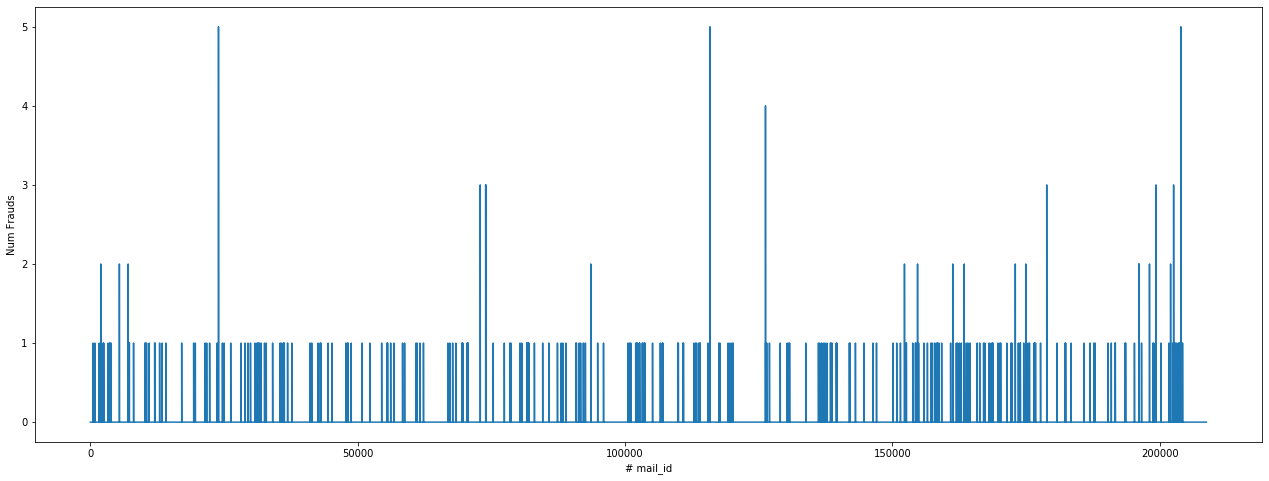

In [5]:
pdata_mail = pdata[['mail_id','simple_journal']].groupby(['mail_id']).sum()

f, (ax) = plt.subplots(1,figsize =(22, 8))
ax = sns.lineplot(x=pdata_mail.index,y=pdata_mail['simple_journal'])
ax.set(ylabel = "Num Frauds")
ax.set(xlabel = "# mail_id")
plt.show()

### IP

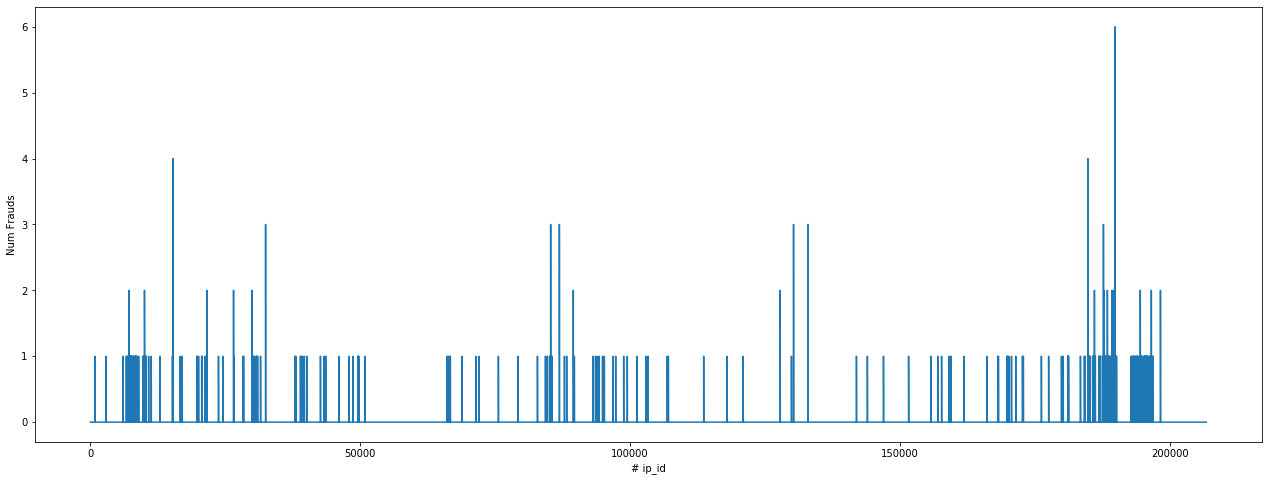

In [6]:
pdata_ip = pdata[['ip_id','simple_journal']].groupby(['ip_id']).sum()

f, (ax) = plt.subplots(1,figsize =(22, 8))
ax = sns.lineplot(x=pdata_ip.index,y=pdata_ip['simple_journal'])
ax.set(ylabel = "Num Frauds")
ax.set(xlabel = "# ip_id")
plt.show()

### Card

KeyboardInterrupt: 

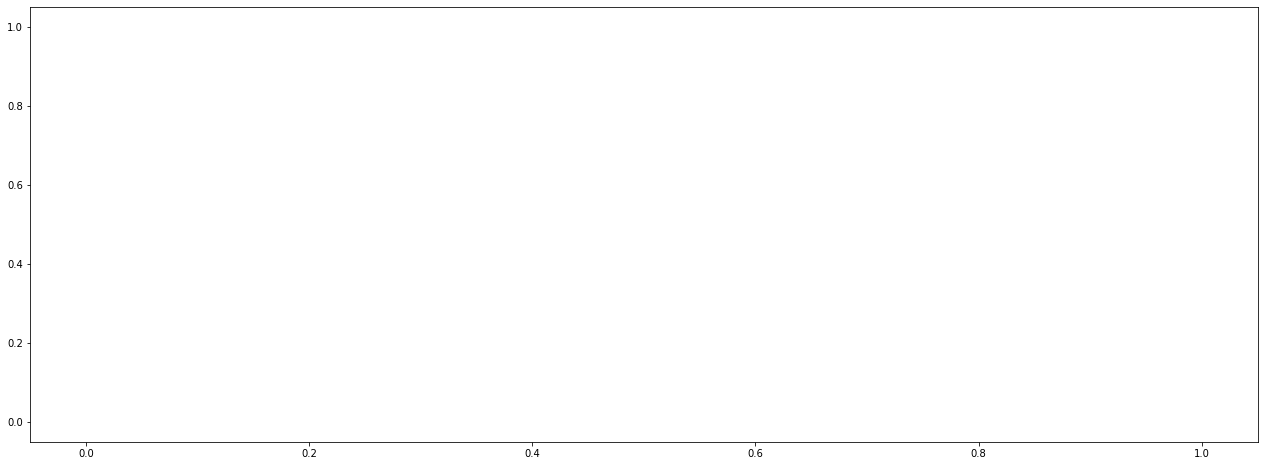

In [7]:
pdata_card = pdata[['card_id','simple_journal']].groupby(['card_id']).sum()

f, (ax) = plt.subplots(1,figsize =(22, 8))
ax = sns.lineplot(x=pdata_card.index,y=pdata_card['simple_journal'])
ax.set(ylabel = "Num Frauds")
ax.set(xlabel = "# card_id")
plt.show()

### Date

In [ ]:
pdata_date = pdata[['date','simple_journal']].groupby(['date']).sum()

f, (ax) = plt.subplots(1,figsize =(22, 8))
ax = sns.lineplot(x=pdata_date.index,y=pdata_date['simple_journal'])
ax.set(ylabel = "Num Frauds")
ax.set(xlabel = "transactions on date")
# ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.xticks(rotation=90)
plt.show()

### Shopperinteraction

In [ ]:
pdata_shopperinteraction = pdata[['shopperinteraction','simple_journal']].groupby(['shopperinteraction']).sum()
f, (ax) = plt.subplots(1,figsize =(22, 8))
ax = sns.barplot(x=pdata_shopperinteraction.index,y=pdata_shopperinteraction['simple_journal'])
ax.set(ylabel = "Num Frauds")
ax.set(xlabel = "# shopper_interaction")
plt.show()

### Card Type
##### The card type used may be an indication which card types to watch. However, the numbers must be normalized in order to see the real ratio.

In [ ]:
pdata_card_type = pdata[['txvariantcode','simple_journal']].groupby(['txvariantcode']).sum()

f, (ax) = plt.subplots(1,figsize =(22, 8))
ax = sns.barplot(x=pdata_card_type.index,y=pdata_card_type['simple_journal'])
ax.set(ylabel = "Num Frauds")
ax.set(xlabel = "# txvariantcode")
plt.show()

### Transaction money
##### The amount of money could be used to check relations between the amount of money used in fraudulent transactions

In [ ]:
pdata_amount = pdata[['amount','simple_journal']].groupby(['amount']).sum()

f, (ax) = plt.subplots(1,figsize =(22, 8))
xas = list(pdata_amount.index)
yas = list(pdata_amount['simple_journal'])
newXas = []
newYas = []
for i in range(len(xas)):
    if yas[i] > 0:
        newXas.append(xas[i])
        newYas.append(yas[i])

ax = sns.lineplot(x=newXas,y=newYas)
ax.set(ylabel = "Frauds")
ax.set(xlabel = "Amount")
plt.show()

### Currency
##### Check which currency is used the most in fraudelent cases

In [ ]:
pdata_amount = pdata[['currencycode','simple_journal']].groupby(['currencycode']).sum()
f, (ax) = plt.subplots(1,figsize =(22, 8))
ax = sns.barplot(x=pdata_amount.index, y=pdata_amount['simple_journal'])
ax.set(ylabel = "Num Frauds")
ax.set(xlabel = "Currency")
plt.show()
